<a href="https://colab.research.google.com/github/eomorozova/modeling_hcos/blob/main/HCO_models_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and helper functions

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import scipy.io
import seaborn as sns

In [2]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# concatenate spiketimes

def concat(spiketimes):

  st = []

  for i in range(len(spiketimes)):
    
    st1=[]

    for j in range(len(spiketimes[i])):

      if spiketimes[i][j].any():
        st1.append(np.concatenate(spiketimes[i][j]))
      else:
        st1.append([])

    st.append(st1)
  
  return st

# Load spiketimes

In [4]:
#load spiketime data

from google.colab import files
uploaded = files.upload()

Saving hco_model_data.mat to hco_model_data.mat


In [5]:
mat  = scipy.io.loadmat('/content/hco_model_data.mat')
allprtile = mat.get('allprtile') # z-scored feature vector (ISIs, phases)
spiketimes = mat.get('st') # spiketimes

In [6]:
st = concat(spiketimes) # concatinated spiketimes

# Generate synthetic spiketime data

In [ ]:
# function to generate synthetic spiketime data from a Poisson distribution

def generate_st(lambda1):
  s = np.random.poisson(lambda1)
  spikes = []
  time = np.random.poisson(lambda1)

  while (time < 900):
    spikes.append(time)
    time = time + np.random.poisson(lambda1)

  return spikes

In [ ]:
# generate spiketimes for two nerurons
st = []
lambda1=[5,10]

for j in range(2):
  st1 = []
  for i in range(10):
    st1.append(generate_st(lambda1[j]))

  st.append(st1)


# Functions to calculate percentiles of ISIs and spike phases and other spike train features 

In [172]:
# ISIs and percentiles of ISIs

def ISIPercentile(spiketimes):

  isiprtile = []

  for j in range(2):
    isiprtile1=[]

    for i in range(len(spiketimes[j])):
      
      if (len(spiketimes[j][i])>1):
        #ISI = np.diff(np.concatenate(spiketimes[j][i]))
        ISI = np.diff(st[j][i])
        isiprtile1.append(np.percentile(ISI,range(0,100,10)).tolist())
      else:
        #isiprtile1.append([])
        isiprtile1.append([0]*10)

    isiprtile.append(isiprtile1)

  return isiprtile


In [183]:
# spike phases and phase percentiles

def PhasePrtile(spiketimes):

  phasesprtile1, phasesprtile2 = [], []

  # phases for the first neuron

  for i in range(len(spiketimes[0])):

    prevspk1,nextspk1,spkphase1 = [],[],[]
    prevspk2,nextspk2,spkphase2 = [],[],[]

    #if (spiketimes[0][i].any()) & (spiketimes[1][i].any()):
    if (len(spiketimes[0][i])!=0) & (len(spiketimes[1][i])!=0):

      #st1 = np.concatenate(spiketimes[0][i])
      #st2 = np.concatenate(spiketimes[1][i])
      st1 = spiketimes[0][i]
      st2 = spiketimes[1][i]
      
      if (max(st2)>min(st1)) & (max(st1)>min(st2)) & (len(st1)>10) & (len(st2)>10):

        # phases of the 1st neuron
        for j in range(len(st1)):

          prev_other_spikes1 = st2[np.where(st2<st1[j])]

          if not prev_other_spikes1.any():
            continue
          else:
            prev_other_spike1 = prev_other_spikes1[-1]
              
          next_other_spikes1 = st2[np.where(st2>st1[j])]

          if not next_other_spikes1.any():
            continue
          else:
            next_other_spike1 = next_other_spikes1[0]

          prevspk1.append(prev_other_spike1)
          nextspk1.append(next_other_spike1)

          spkphase1.append((st1[j] - prev_other_spike1)/(next_other_spike1 - prev_other_spike1))

        # phases of the 2nd neuron
        for j in range(len(st2)):

          prev_other_spikes2 = st1[np.where(st1<st2[j])]

          if not prev_other_spikes2.any():
            continue
          else:
            prev_other_spike2 = prev_other_spikes2[-1]
              
          next_other_spikes2 = st1[np.where(st1>st2[j])]

          if not next_other_spikes2.any():
            continue
          else:
            next_other_spike2 = next_other_spikes2[0]

          prevspk2.append(prev_other_spike2)
          nextspk2.append(next_other_spike2)

          spkphase2.append((st2[j] - prev_other_spike2)/(next_other_spike2 - prev_other_spike2))

      else:
        spkphase1, spkphase2 = [], []

      if spkphase1:
        phasesprtile1.append(np.percentile(spkphase1,range(0,100,10)))
      else:
        phasesprtile1.append([]*10)

      if spkphase2:
        phasesprtile2.append(np.percentile(spkphase2,range(0,100,10)))
      else:
        phasesprtile2.append([]*10)

    else:
      phasesprtile1.append([]*10)
      phasesprtile2.append([]*10)



  return phasesprtile1, phasesprtile2

In [143]:
# calculate firing rates

def FiringRate(spiketimes):

  FR = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):
    for i in range(len(spiketimes[j])):  
      if (len(spiketimes[j][i])>1):
        ISI = np.diff(st[j][i])
        FR[j,i] = np.median(1/ISI)

  return FR

In [244]:
# calculate a metrics for the first approximation of how burst-like spike train is

def BurstLike(spiketimes):

  burstlike = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):

    for i in range(len(spiketimes[j])):
      
      if (len(spiketimes[j][i])>2):
        ISI = np.diff(st[j][i])
        sortedISI = sorted(ISI)
        maxdiffs = max(np.diff(sortedISI))
        argmaxdiffs = np.argmax(np.diff(sortedISI))
        burstlike[j,i] = maxdiffs/sortedISI[argmaxdiffs]
      else:
        burstlike[j,i] = 0

  return burstlike

# Calculate percentiles of ISI and spike phases, firing rates and measure of burstiness

In [227]:
isiprtile = ISIPercentile(st) # percentiles of ISIs 
phaseprtile = PhasePrtile(st) # percentiles of spike phases
FR = FiringRate(st) # median firing rates
burstlike = BurstLike(st) # how burstlike the spike train is

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(0.0, 1.0)

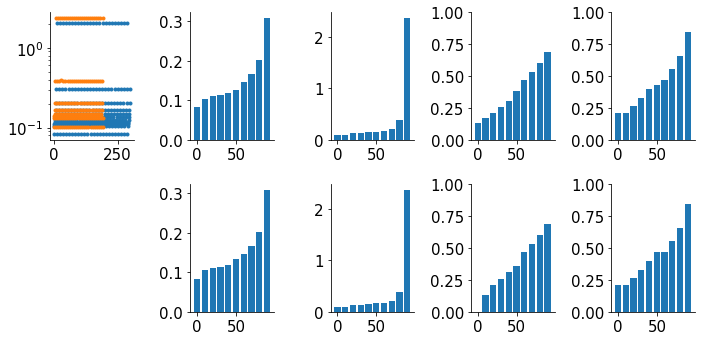

In [127]:
# plot example ISIs, spike phases and ISI and phases tenth percentiles
i=8

plt.figure(figsize=(10,5))
plt.subplot(2,5,1)
if spiketimes[0][i].any():
  plt.plot(np.diff(np.concatenate(spiketimes[0][i])),'.')
if spiketimes[1][i].any():
  plt.plot(np.diff(np.concatenate(spiketimes[1][i])),'.')
plt.yscale('log')
#plt.plot((np.diff(st[0][i])))
#plt.plot(np.diff(st[1][i]))

#isiprtile
plt.subplot(2,5,2)
if isiprtile[0][i]:
  plt.bar(range(0,100,10), isiprtile[0][i],width=8)

plt.subplot(2,5,3)
if isiprtile[1][i]:
  plt.bar(range(0,100,10), isiprtile[1][i],width=8)

plt.subplot(2,5,4)
if phaseprtile[0][i] != []:
  plt.bar(range(0,100,10), phaseprtile[0][i],width=8)
  plt.ylim(0, 1)

plt.subplot(2,5,5)
if phaseprtile[1][i] != []:
  plt.bar(range(0,100,10), phaseprtile[1][i],width=8)
  plt.ylim(0, 1)

plt.subplot(2,5,7)
plt.bar(range(0,100,10), allprtile[i][:10],width=8)
plt.subplot(2,5,8)
plt.bar(range(0,100,10), allprtile[i][10:20],width=8)
plt.subplot(2,5,9)
plt.bar(range(0,100,10), allprtile[i][20:30],width=8)
plt.ylim(0, 1)
plt.subplot(2,5,10)
plt.bar(range(0,100,10), allprtile[i][30:40],width=8)
plt.ylim(0, 1)

In [ ]:
# make a feature vector and z-score it

#features = np.empty(shape=(len(st[0]),40))

i=1

features = np.concatenate(((isiprtile[0][i]), (isiprtile[1][i]), (phaseprtile[0][i]), (phaseprtile[1][i])))
np.append(features,[FR[0,i],FR[1,i]])

#allprtile[1]

In [154]:
features = np.empty(shape=(len(st[0]),40))

# FI-t-SNE approximate algorithm

In [ ]:
from scipy.stats import zscore
allprtile_scaled  = zscore(allprtile)

In [ ]:
#@title Clone FFT-accelerated t-SNE repository
import os, requests
import sys

!git clone https://github.com/KlugerLab/FIt-SNE.git 
!apt-get install libfftw3-dev
!g++ -std=c++11 -O3  /content/FIt-SNE/src/sptree.cpp /content/FIt-SNE/src/tsne.cpp /content/FIt-SNE/src/nbodyfft.cpp  -o /content/FIt-SNE/bin/fast_tsne -pthread -lfftw3 -lm -Wno-address-of-packed-member

sys.path.append(os.path.abspath('/content/FIt-SNE/'))
from fast_tsne import fast_tsne 

In [ ]:
# Do PCA and keep 50 dimensions
X = allprtile_scaled.copy()
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

In [ ]:
#Z = fast_tsne(allprtile_scaled, perplexity=50, stop_early_exag_iter=250)
Z = fast_tsne(X50, perplexity=50, stop_early_exag_iter=250)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


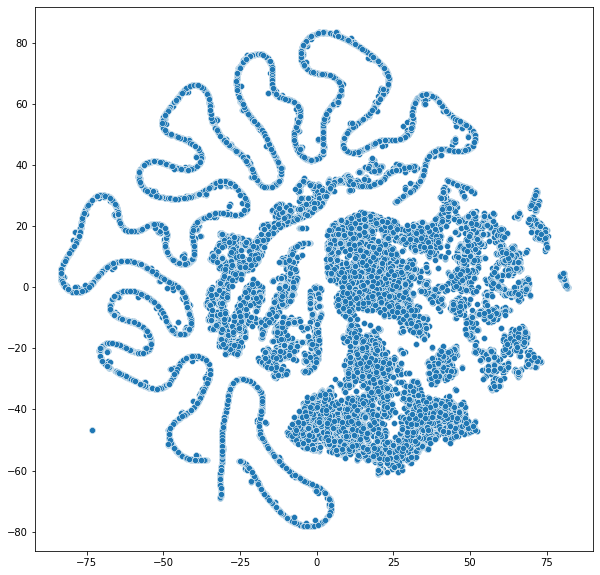

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(Z[:,0], Z[:,1])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=1).fit(Z)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


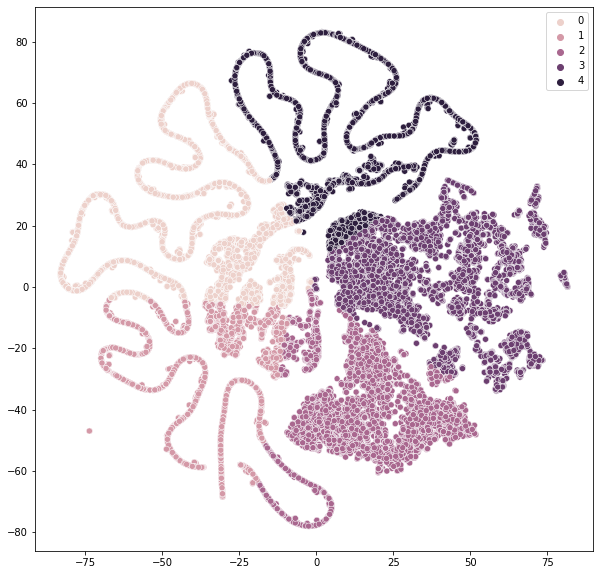

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(Z[:,0], Z[:,1],hue = kmeans.labels_)

# Standard t-SNE/ UMAP, Leiden 

In [ ]:
!pip install scikit-network
from sknetwork.clustering import Louvain

louvain = Louvain()
labels = louvain.fit_transform(Z)

In [ ]:
!pip install -q scanpy
import scanpy as sc

In [ ]:
adata = sc.AnnData(X50)
#adata = sc.AnnData(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [ ]:
adata

AnnData object with n_obs × n_vars = 44998 × 44

In [ ]:
sc.tl.tsne(adata,perplexity=50,n_pcs=10)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [ ]:
sc.tl.umap(adata,min_dist=0.1,gamma=0.1,init_pos=Z)
#sc.tl.umap(adata,min_dist=0.5,gamma=0.1,init_pos='paga')

In [ ]:
#Computing the neighborhood graph
#sc.pp.neighbors(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
#!pip install leidenalg
#sc.tl.leiden(adata)
sc.tl.leiden(adata, key_added='clusters', resolution=0.1)

In [ ]:
sc.tl.paga(adata,groups='clusters')
sc.pl.paga(adata, plot=False) 

In [ ]:
adata

AnnData object with n_obs × n_vars = 44998 × 44
    obs: 'clusters'
    uns: 'tsne', 'neighbors', 'leiden', 'clusters_colors', 'umap'
    obsm: 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

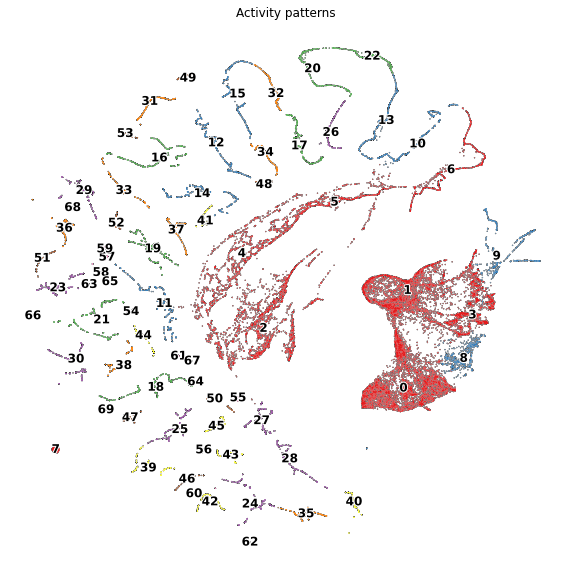

In [ ]:
from matplotlib.pyplot import rc_context

#with rc_context({'figure.figsize': (10, 10)}):
#  sc.pl.tsne(adata, color='clusters', add_outline=True, legend_loc='on data',
#               legend_fontsize=12, legend_fontoutline=2,frameon=False,
#               title='Activity patterns', palette='Set1')
  
with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.umap(adata, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='Activity patterns', palette='Set1')

In [ ]:
plt.figure(figsize=(10,10))
sc.pl.tsne(adata, color='leiden',add_outline=True)